## Plot results of training of a SVDTime Neural Network

The SVDTimeNN is a MultilayerPerceptron estimator of 
The truth data in this case are bin numbers in a series of time shift bins. The result of such a training is a distribution function for a time shift value. From these, it is easy to calculate mean value and standard deviation, but also do a range of approximate probabilistic calculations.

##### Required Python packages

The following python packages are used:
- math (basic python math functions)
- numpy (Vectors and matrices for numerics)
- pandas (Python analogue of Excel tables)
- matplotlib (Plotting library)
- seaborn (Advanced plotting)
- scipy (Scientific computing package)
- scikit-learn (machine learning)

If you get an error message complaining about a missing package, do

pip3 install *_package name_*

##### Other pre-requisites:

A sample of training data, plus binning and bounds information in pickle (*.pkl) files.

In [1]:
import math
import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns
from scipy import stats as stats
from scipy.optimize import minimize_scalar
from sklearn.neural_network import MLPClassifier
from sklearn2pmml import sklearn2pmml, PMMLPipeline
from svd.SVDSimBase import *
from lxml import etree as ET

Welcome to JupyROOT 6.08/06


### Retrieve training sample

In [2]:
n_samples = 1000000
test_fraction = 0.2

pkl_name = 'SVDTime_Training{0}_{1}.pkl'

stockdata = pd.read_pickle(pkl_name.format('Sample', n_samples))
n_samples = len(stockdata)
bounds = pd.read_pickle(pkl_name.format('Bounds', n_samples))
bins = pd.read_pickle(pkl_name.format('Bins', n_samples))
fits = pd.read_pickle(pkl_name.format('Fits', n_samples))
probdf = pd.read_pickle(pkl_name.format('Probs', n_samples))

timearray = bins['midpoint']
timebins = np.unique(bins[['lower','upper']])

#### Set up tau en/decoder

In [3]:
amp_index = bounds[bounds.value == 'amplitude'].index[0]
amp_range = (bounds.ix[amp_index,'low'], bounds.ix[amp_index, 'high'])
tau_index = bounds[bounds.value == 'tau'].index[0]
tau_range = (bounds.ix[tau_index,'low'], bounds.ix[tau_index, 'high'])
coder = tau_encoder(amp_range, tau_range)

/home/kvasnicka/work/belle2_new/externals/v01-05-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


### Now that we have the time shifts and amplitudes, do some plotting.

We want to know the errors and biases of time shifts and amplitudes provided by the network.
We use two kind of plots - simple 2d histograms and contour plots. Both have their advantages and disadvantages. 

#### Error of time shift

In [4]:
image_dir = '/home/kvasnicka/Dropbox/Talks/Elba2017/image/'

In [5]:
table_tsigma = pd.pivot_table(data = fits, values = 't_sigma', index = 't_bin', columns = 'a_bin', aggfunc = 'mean')

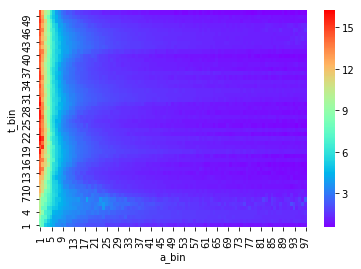

In [6]:
ax = sns.heatmap(table_tsigma, cmap = plt.cm.rainbow)
ax.invert_yaxis()

In [7]:
table_tsigma[np.isnan(table_tsigma)] = 0

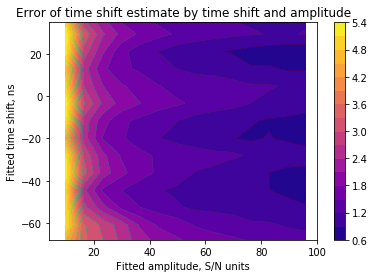

In [8]:
from scipy.interpolate import griddata
import numpy.ma as ma
# define grid.a
nbins = 16
a = np.asarray(fits['a_fit'].groupby(fits.a_bin).aggregate(np.mean))
aa = np.zeros(table_tsigma.shape)
aa[:,] = a
t = np.asarray(fits['t_fit'].groupby(fits.t_bin).aggregate(np.mean))
tt = np.zeros((table_tsigma.shape[1], table_tsigma.shape[0]))
tt[:,] = t
tt = tt.transpose()
ai = np.linspace(np.min(fits.a_fit), np.max(fits.a_fit), nbins, endpoint = True)
ti = np.linspace(np.min(fits.t_fit), np.max(fits.t_fit), nbins, endpoint = True)
gridtable_tsigma = griddata((aa.flatten(),tt.flatten()), np.asarray(table_tsigma).flatten(), (ai[None,:], ti[:,None]), method = 'cubic')
CS = plt.contour(ai, ti, gridtable_tsigma,16,linewidths=0.5,color = 'k')
CS = plt.contourf(ai,ti,gridtable_tsigma,16,cmap=plt.cm.plasma)
plt.colorbar() # draw colorbar
plt.xlim((4,100))
plt.ylim((-68,35))
plt.xlabel('Fitted amplitude, S/N units')
plt.ylabel('Fitted time shift, ns')
plt.title('Error of time shift estimate by time shift and amplitude')
#plt.show()
plt.savefig(image_dir + 'NNTimeShiftError_cont.png')

#### Error of amplitude

In [9]:
table_ampsigma = pd.pivot_table(data = fits, values = 'a_sigma', index = 't_bin', columns = 'a_bin', aggfunc = 'mean')

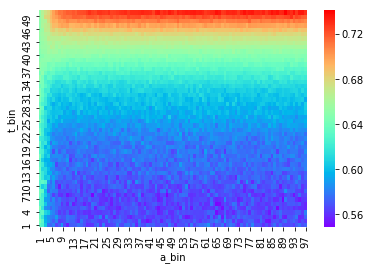

In [10]:
ax = sns.heatmap(table_ampsigma, cmap = plt.cm.rainbow)
ax.invert_yaxis()

In [11]:
table_ampsigma[np.isnan(table_ampsigma)] = 0

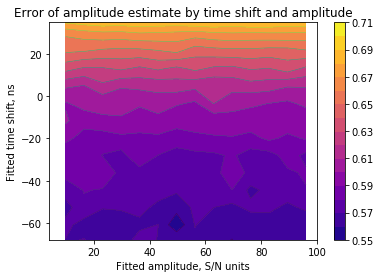

In [12]:
from scipy.interpolate import griddata
import numpy.ma as ma
# define grid.a
nbins = 16
a = np.asarray(fits['a_fit'].groupby(fits.a_bin).aggregate(np.mean))
aa = np.zeros(table_ampsigma.shape)
aa[:,] = a
t = np.asarray(fits['t_fit'].groupby(fits.t_bin).aggregate(np.mean))
tt = np.zeros((table_ampsigma.shape[1], table_ampsigma.shape[0]))
tt[:,] = t
tt = tt.transpose()
ai = np.linspace(np.min(fits.a_fit), np.max(fits.a_fit), nbins, endpoint = True)
ti = np.linspace(np.min(fits.t_fit), np.max(fits.t_fit), nbins, endpoint = True)
gridtable_tsigma = griddata((aa.flatten(),tt.flatten()), np.asarray(table_ampsigma).flatten(), (ai[None,:], ti[:,None]), method = 'cubic')
CS = plt.contour(ai, ti, gridtable_tsigma,16,linewidths=0.5,color = 'k')
CS = plt.contourf(ai,ti,gridtable_tsigma,16,cmap=plt.cm.plasma)
plt.colorbar() # draw colorbar
plt.xlim((4,100))
plt.ylim((-68,35))
plt.xlabel('Fitted amplitude, S/N units')
plt.ylabel('Fitted time shift, ns')
plt.title('Error of amplitude estimate by time shift and amplitude')
#plt.show()
plt.savefig(image_dir + 'NNAmplitudeError_cont.png')

#### Bias of time shift

In [13]:
fits['t_diff'] = fits.apply(lambda row: row.t_fit - row.t_true, axis = 1)
table_tbias = pd.pivot_table(data = fits, values = 't_diff', index = 't_bin', columns = 'a_bin', aggfunc = 'mean')

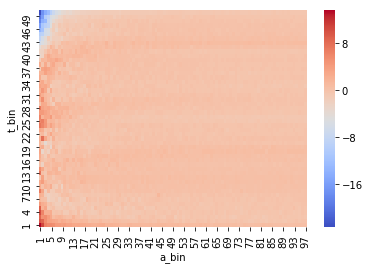

In [14]:
ax = sns.heatmap(table_tbias, cmap = plt.cm.coolwarm)
ax.invert_yaxis()

In [15]:
table_tbias[np.isnan(table_tbias)] = 0

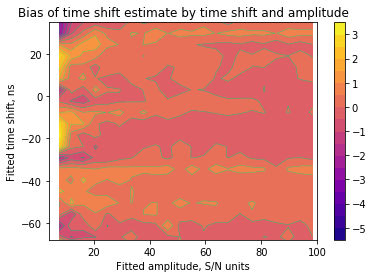

In [16]:
from scipy.interpolate import griddata
import numpy.ma as ma
# define grid.a
nbins = 24
a = np.asarray(fits['a_fit'].groupby(fits.a_bin).aggregate(np.mean))
aa = np.zeros(table_tbias.shape)
aa[:,] = a
t = np.asarray(fits['t_fit'].groupby(fits.t_bin).aggregate(np.mean))
tt = np.zeros((table_tbias.shape[1], table_tbias.shape[0]))
tt[:,] = t
tt = tt.transpose()
ai = np.linspace(np.min(fits.a_fit), np.max(fits.a_fit), nbins, endpoint = True)
ti = np.linspace(np.min(fits.t_fit), np.max(fits.t_fit), nbins, endpoint = True)
gridtable_tsigma = griddata((aa.flatten(),tt.flatten()), np.asarray(table_tbias).flatten(), (ai[None,:], ti[:,None]), method = 'cubic')
CS = plt.contour(ai, ti, gridtable_tsigma,16,linewidths=0.5,color = 'k')
CS = plt.contourf(ai,ti,gridtable_tsigma,16,cmap=plt.cm.plasma)
plt.colorbar() # draw colorbar
plt.xlim((4,100))
plt.ylim((-68,35))
plt.xlabel('Fitted amplitude, S/N units')
plt.ylabel('Fitted time shift, ns')
plt.title('Bias of time shift estimate by time shift and amplitude')
#plt.show()
plt.savefig(image_dir + 'NNTimeShiftBias_cont.png')

#### Bias of amplitude

In [17]:
fits['a_diff'] = fits.apply(lambda row: row.a_fit - row.a_true, axis = 1)
table_abias = pd.pivot_table(data = fits, values = 'a_diff', index = 't_bin', columns = 'a_bin', aggfunc = 'mean')

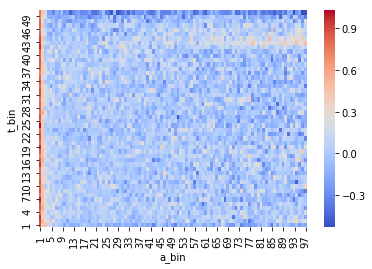

In [18]:
ax = sns.heatmap(table_abias, cmap = plt.cm.coolwarm)
ax.invert_yaxis()

In [19]:
table_abias[np.isnan(table_abias)] = 0

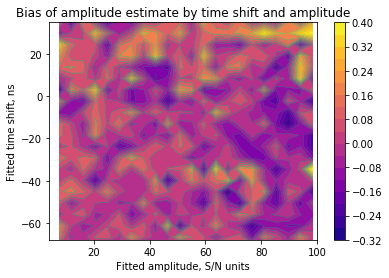

In [20]:
from scipy.interpolate import griddata
import numpy.ma as ma
# define grid.a
nbins = 24
a = np.asarray(fits['a_fit'].groupby(fits.a_bin).aggregate(np.mean))
aa = np.zeros(table_abias.shape)
aa[:,] = a
t = np.asarray(fits['t_fit'].groupby(fits.t_bin).aggregate(np.mean))
tt = np.zeros((table_abias.shape[1], table_abias.shape[0]))
tt[:,] = t
tt = tt.transpose()
ai = np.linspace(np.min(fits.a_fit), np.max(fits.a_fit), nbins, endpoint = True)
ti = np.linspace(np.min(fits.t_fit), np.max(fits.t_fit), nbins, endpoint = True)
gridtable_tsigma = griddata((aa.flatten(),tt.flatten()), np.asarray(table_abias).flatten(), (ai[None,:], ti[:,None]), method = 'cubic')
CS = plt.contour(ai, ti, gridtable_tsigma,16,linewidths=0.5,color = 'k')
CS = plt.contourf(ai,ti,gridtable_tsigma,16,cmap=plt.cm.plasma)
plt.colorbar() # draw colorbar
plt.xlim((4,100))
plt.ylim((-68,35))
plt.xlabel('Fitted amplitude, S/N units')
plt.ylabel('Fitted time shift, ns')
plt.title('Bias of amplitude estimate by time shift and amplitude')
#plt.show()
plt.savefig(image_dir + 'NNAmplitudeBias_cont.png')

#### Bias of time shift vs. waveform width tau

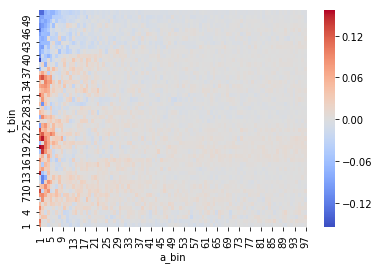

[ 50.   50.5  51.   51.5  52.   52.5  53.   53.5  54.   54.5  55.   55.5
  56.   56.5  57.   57.5  58.   58.5  59.   59.5]


In [21]:
def corr(group) :
    c = np.cov(group.tau, group.t_diff) / np.cov(group.tau, group.tau)
    return pd.Series({'corr': c[0,1]})

tau_bins = np.arange(50, 60, 0.5)
print(tau_bins)
t_diff_tau_corrs = fits.groupby(['t_bin', 'a_bin']).apply(corr).reset_index()
table_t_diff_tau_corr = pd.pivot_table(data = t_diff_tau_corrs, values = 'corr', index = 't_bin', columns = 'a_bin', aggfunc = 'mean')
ax = sns.heatmap(table_t_diff_tau_corr, cmap = plt.cm.coolwarm)
ax.invert_yaxis()

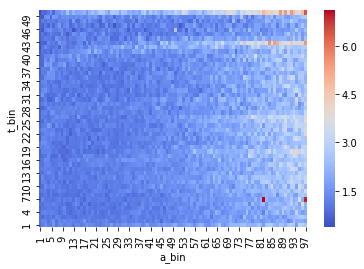

In [22]:
table_chi2 = pd.pivot_table(data = fits, values = 'chi2_ndf', index = 't_bin', columns = 'a_bin', aggfunc = np.mean)
ax = sns.heatmap(table_chi2, cmap = plt.cm.coolwarm)
ax.invert_yaxis()

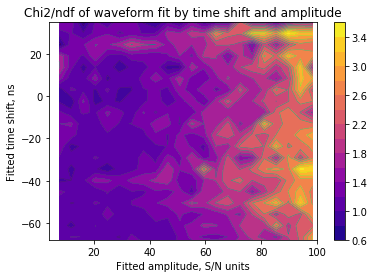

In [23]:
from scipy.interpolate import griddata
import numpy.ma as ma
# define grid.a
nbins = 24
a = np.asarray(fits['a_fit'].groupby(fits.a_bin).aggregate(np.mean))
aa = np.zeros(table_abias.shape)
aa[:,] = a
t = np.asarray(fits['t_fit'].groupby(fits.t_bin).aggregate(np.mean))
tt = np.zeros((table_chi2.shape[1], table_chi2.shape[0]))
tt[:,] = t
tt = tt.transpose()
ai = np.linspace(np.min(fits.a_fit), np.max(fits.a_fit), nbins, endpoint = True)
ti = np.linspace(np.min(fits.t_fit), np.max(fits.t_fit), nbins, endpoint = True)
gridtable_chi2 = griddata((aa.flatten(),tt.flatten()), np.asarray(table_chi2).flatten(), (ai[None,:], ti[:,None]), method = 'cubic')
CS = plt.contour(ai, ti, gridtable_chi2,16,linewidths=0.5,color = 'k')
CS = plt.contourf(ai,ti,gridtable_chi2,16,cmap=plt.cm.plasma)
plt.colorbar() # draw colorbar
plt.xlim((4,100))
plt.ylim((-68,35))
plt.xlabel('Fitted amplitude, S/N units')
plt.ylabel('Fitted time shift, ns')
plt.title('Chi2/ndf of waveform fit by time shift and amplitude')
#plt.show()
plt.savefig(image_dir + 'NNChi2_cont.png')

In [24]:
select_t0_fits = fits[
    np.logical_and(
        np.logical_and(
            np.abs(fits.t_true) < 1,
            np.abs(fits.tau - 250) < 5
        ),
        fits.a_true > 10
    )]

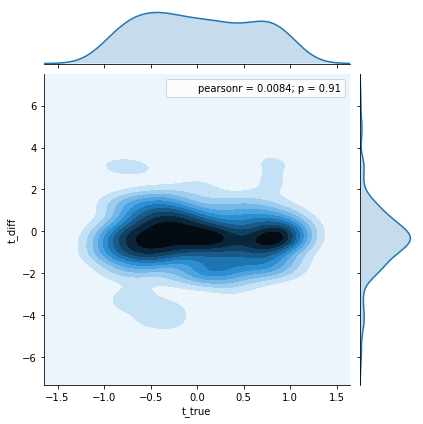

In [25]:
sns.jointplot(data = select_t0_fits, x = 't_true', y = 't_diff', kind = 'kde')

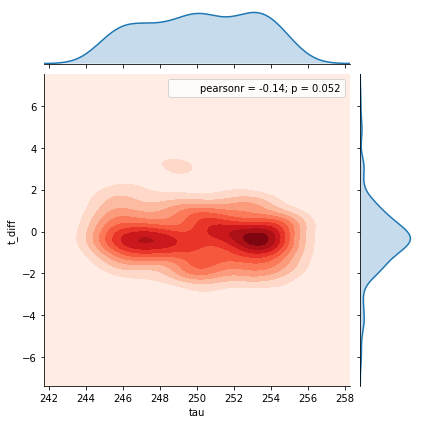

In [26]:
sns.jointplot(data = select_t0_fits, x = 'tau', y = 't_diff', kind = 'kde', cmap = plt.cm.Reds)

In [27]:
select_t0_fits.head()

,a_fit,a_sigma,chi2_ndf,t_fit,t_sigma,t_true,tau,a_true,t_bin,a_bin,t_diff,a_diff
18947,25.410571,0.608986,0.097498,-1.680162,2.139597,-0.525176,251.420323,26.092239,32,24,-1.154986,-0.681668
24527,85.032871,0.608081,2.202788,-1.560156,1.089020,-0.946802,253.079656,86.143713,31,84,-0.613354,-1.110843
29583,98.700858,0.608150,10.161426,-1.877462,0.928977,-0.771909,252.547737,99.123239,31,97,-1.105553,-0.422381
34799,18.489858,0.610721,4.431492,-0.400027,2.736900,-0.328593,250.336816,18.223646,32,16,-0.071434,0.266211
55983,77.648088,0.610265,0.455835,-0.786401,1.331978,-0.341102,250.522407,77.661251,32,75,-0.445299,-0.013163


<function __main__.plot_data>

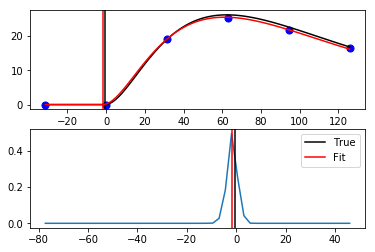

a_fit        25.410571
a_sigma       0.608986
chi2_ndf      0.097498
t_fit        -1.680162
t_sigma       2.139597
t_true       -0.525176
tau         251.420323
a_true       26.092239
t_bin        32.000000
a_bin        24.000000
t_diff       -1.154986
a_diff       -0.681668
Name: 18947, dtype: float64


[IPKernelApp] WARNING | Widget Javascript not detected.  It may not be installed or enabled properly.
Widget Javascript not detected.  It may not be installed or enabled properly.
/home/kvasnicka/work/belle2_new/externals/v01-05-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel/__main__.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/kvasnicka/work/belle2_new/externals/v01-05-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel/__main__.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/kvasnicka/work/belle2_new/externals/v01-05-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel/__main

In [28]:
from ipywidgets import *

def plot_data(irow):
    '''
    Given row number, plot signals, true waveform and fitted waveform, and plot probabilities.
    '''
    fig, axarr = plt.subplots(2, 1, sharex=False, sharey = False)
    # The first plot is data
    sample_times = np.linspace(-dt, 4*dt, 6, endpoint = True)
    function_times = np.linspace(-dt, 4*dt, 100, endpoint = True)
    samples = stockdata.ix[int(irow),['s'+str(i) for i in range(1,7)]]
    a_fit = fits.ix[int(irow), 'a_fit']
    a_true = fits.ix[int(irow), 'a_true']
    t_fit = fits.ix[int(irow), 't_fit']
    t_true = fits.ix[int(irow), 't_true']
    tau_true = fits.ix[int(irow), 'tau']
    tau_fit = tau_true
    axarr[0].scatter(sample_times,samples, c = 'b', marker = 'o', s=50, label = 'Data')
    axarr[0].plot(function_times, a_true * betaprime_wave(function_times - t_true, tau = tau_true), 
                  c = 'k', label = 'True')
    axarr[0].axvline(x = t_true, c = 'k', label = 'True')
    axarr[0].plot(function_times, a_fit * betaprime_wave(function_times - t_fit, tau = tau_fit), 
                  c = 'r', label = 'Fit')
    axarr[0].axvline(x = t_fit, c = 'r', label = 'Fit')
    # The second plot is probability density
    axarr[1].plot(timearray, probdf.ix[int(irow),:].values)
    axarr[1].axvline(x = t_true, c = 'k', label = 'True')
    axarr[1].axvline(x = t_fit, c = 'r', label = 'Fit')
    plt.legend()
    #plt.show()
    plt.savefig(image_dir + 'fit.png')
    print(fits.ix[int(irow),:])
    
interact(plot_data, irow = [int(x) for x in select_t0_fits.index])

In [29]:
fits.head()

,a_fit,a_sigma,chi2_ndf,t_fit,t_sigma,t_true,tau,a_true,t_bin,a_bin,t_diff,a_diff
0,26.049484,0.679230,0.245545,34.039376,2.110170,34.312308,299.675373,26.404676,45,24,-0.272932,-0.355192
5,67.068695,0.722536,0.600857,45.800065,0.529384,46.574529,265.970206,67.917575,50,65,-0.774464,-0.848880
9,20.384141,0.551966,0.400717,-69.323751,2.977907,-68.858706,282.223130,19.881322,4,17,-0.465045,0.502819
15,93.088691,0.563739,0.873600,-37.035168,0.355508,-38.107439,282.486988,91.892018,17,89,1.072271,1.196673
16,11.817565,0.584027,0.909527,-7.197980,4.410605,-11.504902,295.155383,11.874301,27,9,4.306923,-0.056737


Let us make aa table containing all the data of selected fits.

In [30]:
select_fits_frame = pd.concat([stockdata, probdf, select_t0_fits], axis = 1, join = 'inner' )
select_fits_frame.head()

,test,amplitude,t0,tau,sigma,s1,s2,s3,s4,s5,...,chi2_ndf,t_fit,t_sigma,t_true,tau,a_true,t_bin,a_bin,t_diff,a_diff
18947,0.181804,26.092239,-0.525176,251.420323,1.152042,0.0,0.0,19.096520,25.172686,21.700591,...,0.097498,-1.680162,2.139597,-0.525176,251.420323,26.092239,32,24,-1.154986,-0.681668
24527,0.119546,86.143713,-0.946802,253.079656,1.445215,0.0,0.0,63.658351,85.800386,73.345491,...,2.202788,-1.560156,1.089020,-0.946802,253.079656,86.143713,31,84,-0.613354,-1.110843
29583,0.035661,99.123239,-0.771909,252.547737,3.183415,0.0,0.0,72.249456,96.437317,87.013475,...,10.161426,-1.877462,0.928977,-0.771909,252.547737,99.123239,31,97,-1.105553,-0.422381
34799,0.049947,18.223646,-0.328593,250.336816,2.573443,0.0,0.0,13.600459,16.320550,17.874889,...,4.431492,-0.400027,2.736900,-0.328593,250.336816,18.223646,32,16,-0.071434,0.266211
55983,0.059999,77.661251,-0.341102,250.522407,3.350254,0.0,0.0,56.413639,77.606064,66.860609,...,0.455835,-0.786401,1.331978,-0.341102,250.522407,77.661251,32,75,-0.445299,-0.013163


In [31]:
select_fits_frame.columns

Index([      'test',  'amplitude',         't0',        'tau',      'sigma',
               's1',         's2',         's3',         's4',         's5',
               's6', 'normed_tau',     't0_bin',       'abin',            0,
                  1,            2,            3,            4,            5,
                  6,            7,            8,            9,           10,
                 11,           12,           13,           14,           15,
                 16,           17,           18,           19,           20,
                 21,           22,           23,           24,           25,
                 26,           27,           28,           29,           30,
                 31,           32,           33,           34,           35,
                 36,           37,           38,           39,           40,
                 41,           42,           43,           44,           45,
                 46,           47,           48,           49,      'a_fit',

In [32]:
len(select_fits_frame)

199

In [33]:
select_fits_frame.to_csv('test_sample.csv')